In [1]:
import sys, os
sys.path.append(os.path.abspath("../"))

In [2]:
from art_enrich import lib as tab

In [3]:
from tabulation import Lifetimes
from tabulation import IMF

In [4]:
%matplotlib inline
import betterplotlib as bpl
import numpy as np
from scipy import integrate
from scipy import optimize
bpl.presentation_style()
bpl.presentation_style()

In [5]:
tab.detailed_enrichment_init()

In [6]:
def get_rate(age, z, idx):
    return tab.get_ejecta_rate_sn_ii_py(age, z)[idx] 

def get_ejecta_timestep(age, z, dt, mass, idx):
    return tab.get_ejecta_timestep_snii_py(age, z, mass, dt)[idx]

In [7]:
z_sn = [0, 0.001, 0.004, 0.02]

(array([  1.,   3.,   4.,   4.,   3.,  10.,   7.,  14.,  27.,  23.,  47.,
         47.,  62.,  81.,  79.,  88.,  72., 103.,  64.,  57.,  55.,  43.,
         25.,  24.,  21.,  13.,   9.,   6.,   4.,   1.,   3.]),
 array([1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
        2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
        4. , 4.1, 4.2, 4.3, 4.4, 4.5]),
 <a list of 31 Patch objects>)

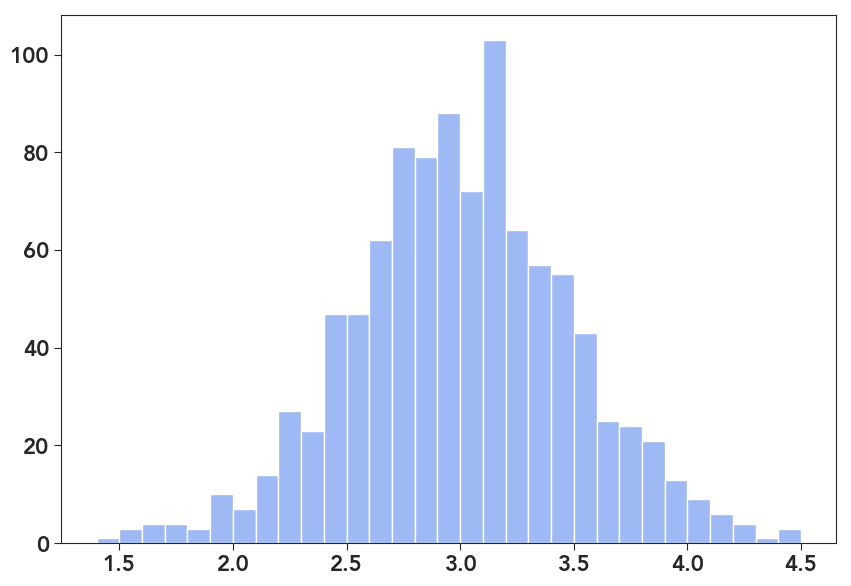

In [8]:
bpl.hist(np.random.normal(3, 0.5, 1000))

In [9]:
class EjectaHistory(object):
    def __init__(self, ages):
        self.ages = ages
        dts = []
        for idx in range(len(ages) - 1):
            dts.append(self.ages[idx + 1] - self.ages[idx])
        # add zero on the end for the last age
        dts.append(0)
        
        self.dts = np.array(dts)
        
        # make SN rates
    def rates(self, z, idx): 
        return np.array([get_rate(a, z, idx) for a in self.ages])
    def ejecta_timestep(self, z, mass, idx):
        return np.array([get_ejecta_timestep(a, z, dt, mass, idx)
                         for a, dt in zip(self.ages, self.dts)])
    def ejecta_cumulative(self, z, mass, idx):
        each_timestep = self.ejecta_timestep(z, mass, idx)
        return np.cumsum(each_timestep)

In [10]:
def make_rand_ages(max_age=50E6):
    dts = 10**(np.abs(np.random.normal(3, 0.5, 1000000)))
    ages = [0]
    idx = 0
    while ages[-1] < max_age:
        ages.append(ages[-1] + dts[idx])
        idx += 1
        
    return np.array(ages)  # last dt  included

In [11]:
perfect = EjectaHistory(np.concatenate([[0], np.arange(3E6, 5E7, 1000)]))
rand_1 = EjectaHistory(make_rand_ages())
rand_2 = EjectaHistory(make_rand_ages())
rand_3 = EjectaHistory(make_rand_ages())
rand_4 = EjectaHistory(make_rand_ages())
rand_5 = EjectaHistory(make_rand_ages())

Text(100000000.0, 0.0109743508039993, '0.0110')

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


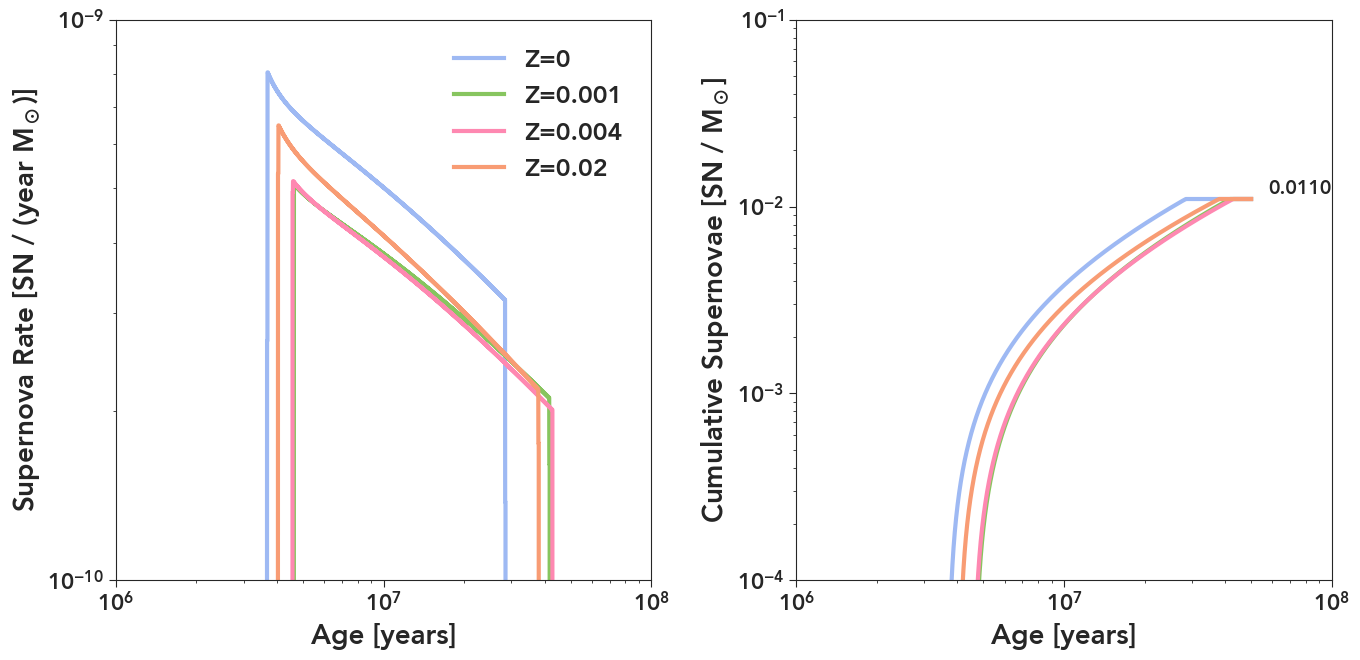

In [12]:
fig, axs = bpl.subplots(ncols=2, figsize=[14, 7])
ax0, ax1 = axs

for z in z_sn:
    ax0.plot(perfect.ages, perfect.rates(z, 9), label="Z={}".format(z))
    ax1.plot(perfect.ages, perfect.ejecta_cumulative(z, 1, 9))

ax0.legend(frameon=False)
for ax in axs:
    ax.set_yscale("log")
    ax.set_xscale("log")
    
ax0.add_labels("Age [years]", "Supernova Rate [SN / (year $M_\odot$)]")
ax0.set_limits(1E6, 1E8, 1E-10, 1E-9)

ax1.add_labels("Age [years]", "Cumulative Supernovae [SN / $M_\odot$]")
ax1.set_limits(1E6, 1E8, 1E-4, 0.1)

last_value = perfect.ejecta_cumulative(z, 1, 9)[-1]
ax1.add_text(x=1E8, y=last_value, text="{:.4f}".format(last_value),
             ha="right", va="bottom", fontsize=14)

# fig.savefig("plots/number_sn.png")

# See when SN happen

We have the cumulative SN rate with very small timesteps, so can multiply by the stellar mass to see when SN happen.

In [13]:
def get_sn_ages(ejecta_obj, z, mass, threshold):
    cumulative = ejecta_obj.ejecta_cumulative(z, mass, 9)
    
    sn_ages = []
    for idx in range(len(ejecta_obj.ages)):
        if cumulative[idx] > threshold:
            sn_ages.append(ejecta_obj.ages[idx])
            cumulative -= 1
    return sn_ages

In [14]:
lt = Lifetimes("Raiteri_96")
imf = IMF("Kroupa", 0.1, 50, total_mass=1)

In [15]:
def print_sn_stats(ejecta_obj, threshold):
    for m in [1E3, 6E3, 1E4, 1E5, 1E6]:
        print()
        for z in z_sn:
            sn_ages = get_sn_ages(ejecta_obj, z, m, threshold)

            age_50 = lt.lifetime(50, z)
            first_sn = sn_ages[0]
            diff = first_sn - age_50
            first_sn_m = lt.turnoff_mass(first_sn, z)[0]
            # print the difference in age between the true first age and the discrete first age
            print("M = {:.1E}, Z = {:.3f}, true = {:.2E}, discrete = {:.2E}, diff = {:.2E}, m = {:.1f}".format(m, z, age_50, first_sn, diff, first_sn_m))


In [16]:
print_sn_stats(perfect, 1.0)


M = 1.0E+03, Z = 0.000, true = 3.68E+06, discrete = 5.08E+06, diff = 1.40E+06, m = 30.6
M = 1.0E+03, Z = 0.001, true = 4.62E+06, discrete = 6.76E+06, diff = 2.14E+06, m = 30.6
M = 1.0E+03, Z = 0.004, true = 4.57E+06, discrete = 6.70E+06, diff = 2.13E+06, m = 30.6
M = 1.0E+03, Z = 0.020, true = 4.03E+06, discrete = 5.78E+06, diff = 1.75E+06, m = 30.6

M = 6.0E+03, Z = 0.000, true = 3.68E+06, discrete = 3.89E+06, diff = 2.13E+05, m = 44.9
M = 6.0E+03, Z = 0.001, true = 4.62E+06, discrete = 4.96E+06, diff = 3.33E+05, m = 44.9
M = 6.0E+03, Z = 0.004, true = 4.57E+06, discrete = 4.90E+06, diff = 3.29E+05, m = 44.9
M = 6.0E+03, Z = 0.020, true = 4.03E+06, discrete = 4.30E+06, diff = 2.64E+05, m = 44.9

M = 1.0E+04, Z = 0.000, true = 3.68E+06, discrete = 3.81E+06, diff = 1.27E+05, m = 46.8
M = 1.0E+04, Z = 0.001, true = 4.62E+06, discrete = 4.82E+06, diff = 1.98E+05, m = 46.8
M = 1.0E+04, Z = 0.004, true = 4.57E+06, discrete = 4.77E+06, diff = 1.96E+05, m = 46.8
M = 1.0E+04, Z = 0.020, true 

In [17]:
print_sn_stats(perfect, 0.5)


M = 1.0E+03, Z = 0.000, true = 3.68E+06, discrete = 4.35E+06, diff = 6.68E+05, m = 37.6
M = 1.0E+03, Z = 0.001, true = 4.62E+06, discrete = 5.65E+06, diff = 1.03E+06, m = 37.6
M = 1.0E+03, Z = 0.004, true = 4.57E+06, discrete = 5.59E+06, diff = 1.02E+06, m = 37.6
M = 1.0E+03, Z = 0.020, true = 4.03E+06, discrete = 4.86E+06, diff = 8.30E+05, m = 37.6

M = 6.0E+03, Z = 0.000, true = 3.68E+06, discrete = 3.78E+06, diff = 1.05E+05, m = 47.3
M = 6.0E+03, Z = 0.001, true = 4.62E+06, discrete = 4.79E+06, diff = 1.65E+05, m = 47.3
M = 6.0E+03, Z = 0.004, true = 4.57E+06, discrete = 4.73E+06, diff = 1.63E+05, m = 47.3
M = 6.0E+03, Z = 0.020, true = 4.03E+06, discrete = 4.16E+06, diff = 1.30E+05, m = 47.3

M = 1.0E+04, Z = 0.000, true = 3.68E+06, discrete = 3.74E+06, diff = 6.27E+04, m = 48.3
M = 1.0E+04, Z = 0.001, true = 4.62E+06, discrete = 4.72E+06, diff = 9.84E+04, m = 48.3
M = 1.0E+04, Z = 0.004, true = 4.57E+06, discrete = 4.67E+06, diff = 9.78E+04, m = 48.3
M = 1.0E+04, Z = 0.020, true 

In [18]:
print_sn_stats(perfect, 0.001)


M = 1.0E+03, Z = 0.000, true = 3.68E+06, discrete = 3.67E+06, diff = -6.26E+03, m = 50.2
M = 1.0E+03, Z = 0.001, true = 4.62E+06, discrete = 4.62E+06, diff = 2.37E+03, m = 50.0
M = 1.0E+03, Z = 0.004, true = 4.57E+06, discrete = 4.57E+06, diff = 1.76E+03, m = 50.0
M = 1.0E+03, Z = 0.020, true = 4.03E+06, discrete = 4.03E+06, diff = -1.12E+03, m = 50.0

M = 6.0E+03, Z = 0.000, true = 3.68E+06, discrete = 3.67E+06, diff = -9.26E+03, m = 50.3
M = 6.0E+03, Z = 0.001, true = 4.62E+06, discrete = 4.61E+06, diff = -1.26E+04, m = 50.2
M = 6.0E+03, Z = 0.004, true = 4.57E+06, discrete = 4.57E+06, diff = -2.37E+02, m = 50.0
M = 6.0E+03, Z = 0.020, true = 4.03E+06, discrete = 4.03E+06, diff = -2.12E+03, m = 50.0

M = 1.0E+04, Z = 0.000, true = 3.68E+06, discrete = 3.67E+06, diff = -9.26E+03, m = 50.3
M = 1.0E+04, Z = 0.001, true = 4.62E+06, discrete = 4.61E+06, diff = -1.46E+04, m = 50.3
M = 1.0E+04, Z = 0.004, true = 4.57E+06, discrete = 4.57E+06, diff = -2.37E+02, m = 50.0
M = 1.0E+04, Z = 0.0

In [19]:
def first_sn_mass_imf(z, m_cluster, threshold):
    imf.normalize(m_cluster)
    
    def to_minimize(m):
        return np.abs(integrate.quad(imf.normalized_dn_dm, m, 50)[0] - threshold)
    
    return optimize.minimize(to_minimize, 35).x[0]

In [20]:
first_sn_mass_imf(0, 1000, 1.0)

30.569802666091682

In [21]:
def print_sn_stats_imf(ejecta_obj, threshold):
    for m in [1E3, 6E3, 1E4, 1E5, 1E6]:
        print()
        for z in z_sn:
            age_50 = lt.lifetime(50, z)
            first_sn_m = first_sn_mass_imf(z, m, threshold)
            first_sn_age = lt.lifetime(first_sn_m, z)
            diff = first_sn_age - age_50
            # print the difference in age between the true first age and the discrete first age
            print("M = {:.1E}, Z = {:.3f}, true = {:.2E}, discrete = {:.2E}, diff = {:.2E}, m = {:.1f}".format(m, z, age_50, first_sn_age, diff, first_sn_m))



In [22]:
print_sn_stats_imf(perfect, 1.0)


M = 1.0E+03, Z = 0.000, true = 3.68E+06, discrete = 5.08E+06, diff = 1.40E+06, m = 30.6
M = 1.0E+03, Z = 0.001, true = 4.62E+06, discrete = 6.76E+06, diff = 2.14E+06, m = 30.6
M = 1.0E+03, Z = 0.004, true = 4.57E+06, discrete = 6.70E+06, diff = 2.13E+06, m = 30.6
M = 1.0E+03, Z = 0.020, true = 4.03E+06, discrete = 5.78E+06, diff = 1.75E+06, m = 30.6

M = 6.0E+03, Z = 0.000, true = 3.68E+06, discrete = 3.89E+06, diff = 2.12E+05, m = 44.9
M = 6.0E+03, Z = 0.001, true = 4.62E+06, discrete = 4.95E+06, diff = 3.33E+05, m = 44.9
M = 6.0E+03, Z = 0.004, true = 4.57E+06, discrete = 4.90E+06, diff = 3.29E+05, m = 44.9
M = 6.0E+03, Z = 0.020, true = 4.03E+06, discrete = 4.30E+06, diff = 2.64E+05, m = 44.9

M = 1.0E+04, Z = 0.000, true = 3.68E+06, discrete = 3.81E+06, diff = 1.26E+05, m = 46.8
M = 1.0E+04, Z = 0.001, true = 4.62E+06, discrete = 4.82E+06, diff = 1.99E+05, m = 46.8
M = 1.0E+04, Z = 0.004, true = 4.57E+06, discrete = 4.77E+06, diff = 1.96E+05, m = 46.8
M = 1.0E+04, Z = 0.020, true 

In [25]:
print_sn_stats_imf(perfect, 0.5)


M = 1.0E+03, Z = 0.000, true = 3.68E+06, discrete = 4.35E+06, diff = 6.67E+05, m = 37.6
M = 1.0E+03, Z = 0.001, true = 4.62E+06, discrete = 5.65E+06, diff = 1.03E+06, m = 37.6
M = 1.0E+03, Z = 0.004, true = 4.57E+06, discrete = 5.59E+06, diff = 1.02E+06, m = 37.6
M = 1.0E+03, Z = 0.020, true = 4.03E+06, discrete = 4.86E+06, diff = 8.29E+05, m = 37.6

M = 6.0E+03, Z = 0.000, true = 3.68E+06, discrete = 3.78E+06, diff = 1.05E+05, m = 47.3
M = 6.0E+03, Z = 0.001, true = 4.62E+06, discrete = 4.79E+06, diff = 1.65E+05, m = 47.3
M = 6.0E+03, Z = 0.004, true = 4.57E+06, discrete = 4.73E+06, diff = 1.63E+05, m = 47.3
M = 6.0E+03, Z = 0.020, true = 4.03E+06, discrete = 4.16E+06, diff = 1.30E+05, m = 47.3

M = 1.0E+04, Z = 0.000, true = 3.68E+06, discrete = 3.74E+06, diff = 6.24E+04, m = 48.3
M = 1.0E+04, Z = 0.001, true = 4.62E+06, discrete = 4.72E+06, diff = 9.87E+04, m = 48.3
M = 1.0E+04, Z = 0.004, true = 4.57E+06, discrete = 4.67E+06, diff = 9.74E+04, m = 48.3
M = 1.0E+04, Z = 0.020, true 

In [26]:
print_sn_stats_imf(perfect, 0.1)


M = 1.0E+03, Z = 0.000, true = 3.68E+06, discrete = 3.81E+06, diff = 1.26E+05, m = 46.8
M = 1.0E+03, Z = 0.001, true = 4.62E+06, discrete = 4.82E+06, diff = 1.99E+05, m = 46.8
M = 1.0E+03, Z = 0.004, true = 4.57E+06, discrete = 4.77E+06, diff = 1.96E+05, m = 46.8
M = 1.0E+03, Z = 0.020, true = 4.03E+06, discrete = 4.19E+06, diff = 1.56E+05, m = 46.8

M = 6.0E+03, Z = 0.000, true = 3.68E+06, discrete = 3.70E+06, diff = 2.07E+04, m = 49.4
M = 6.0E+03, Z = 0.001, true = 4.62E+06, discrete = 4.65E+06, diff = 3.28E+04, m = 49.4
M = 6.0E+03, Z = 0.004, true = 4.57E+06, discrete = 4.60E+06, diff = 3.23E+04, m = 49.4
M = 6.0E+03, Z = 0.020, true = 4.03E+06, discrete = 4.06E+06, diff = 2.57E+04, m = 49.4

M = 1.0E+04, Z = 0.000, true = 3.68E+06, discrete = 3.69E+06, diff = 1.24E+04, m = 49.7
M = 1.0E+04, Z = 0.001, true = 4.62E+06, discrete = 4.64E+06, diff = 1.97E+04, m = 49.7
M = 1.0E+04, Z = 0.004, true = 4.57E+06, discrete = 4.59E+06, diff = 1.94E+04, m = 49.7
M = 1.0E+04, Z = 0.020, true 